# Lab 12 - Training Deep Convolutional Neural Network


Name your file to (first 2 student ID digit)_(last 4 student ID digit)*4.ipynb

## Lab Instruction

In this lab, you will learn to train a deep convolutional neural network using Keras library with Tensorflow backend. We will use  Cat vs Dog dataset.

See https://www.kaggle.com/c/dogs-vs-cats/data


### Your Turn! Dog or Cat Application

Now, it time to put everything together and develop and Cat vs Dog classifier model. Assume that you and your company want to get more attraction on your product by launching a new product that can classify whether it is a dog or a cat. You have decide that you want a precision more than 90 - 95% in order to launch to product.

You have a cat and dog dataset contain total of 25000 images, 12500 for cat and other half for a dog.

After successfully develop this model, you can try to play with it to see how it perform. (You can upload your selfies image to see you are a dog or a cat)

Some note before start a project:
1. You have to load a data into a project using any method
**suggest**
   

```
 !wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
 !unzip -qq Cat_Dog_data.zip
```


2. You have to plan on how you will split a data. (or no need for suggest method)
3. You have to preprocess your data before feed into a network. For example, cropping, padding, etc.
4. You can come up with any model or use pre-train model. It depend on you!

You have two week for this project so that you can compete with your competitor app! Now, create a new Jupyter notebook and start building a model!

In [5]:
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import callbacks
from keras import backend as K
from keras.preprocessing import image
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from keras.utils import np_utils
# from keras.layers.convolutional import  MaxPooling2D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# %load _utils
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from keras import backend as K

# Test
def print_hello():
    print('Hello')

# define a function to plot the result from training step
def show_result(history):

    # Print the result from the last epoch
    print('Last train accuracy: %s'%history.history['acc'][-1])
    print('Last validation accuracy: %s'%history.history['val_acc'][-1])

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['acc']
    val_acc = history.history['val_acc']

    epochs = range(1, len(loss) + 1)

    # Define a subplot
    fig, axs = plt.subplots(1,2,figsize=(15,4))

    # Plot loss
    loss_plot = axs[0]

    loss_plot.plot(epochs, loss, 'c--', label='Training loss')
    loss_plot.plot(epochs, val_loss, 'b', label='Validation loss')
    loss_plot.set_title('Training and validation loss')
    loss_plot.set_xlabel('Epochs')
    loss_plot.set_ylabel('Loss')
    loss_plot.legend()

    # Plot accuracy
    acc_plot = axs[1]

    acc_plot.plot(epochs, acc, 'c--', label='Training acc')
    acc_plot.plot(epochs, val_acc, 'b', label='Validation acc')
    acc_plot.set_title('Training and validation accuracy')
    acc_plot.set_xlabel('Epochs')
    acc_plot.set_ylabel('Accuracy')
    acc_plot.legend()

# Define an evaluation function to print the evaluation result
def evaluation_report(model,features,labels):

    # Calculate result
    result = model.evaluate(features,labels,verbose=False)

    # Predict and convert into a class
    pred_class = model.predict(features).argmax(axis=1)
    labels = labels.argmax(axis=1)
    # Show report
    print(confusion_matrix(labels,pred_class))
    print(classification_report(labels,pred_class))
    print("Loss: %s Accuracy: %s" %(result[0],result[1]))

    return pred_class


# Show a subplot of the incorrect predict data
def show_false_prediction(predict, feature, label, img_size=28, channel=1):

    false_pred = feature[(predict != label).tolist()]
    actual_label = label[(predict != label).tolist()]
    false_label = predict[(predict != label).tolist()]
    if channel == 3:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size,channel)
    elif channel == 1:
        false_pred = false_pred.reshape(false_pred.shape[0],img_size,img_size)
    else:
        raise ValueError('Must be RGB or gray scale image')

    print(false_pred.shape)

    fig, ax = plt.subplots(3,10,figsize=(15,6))
    fig.suptitle('The incorrect prediction')

    for i in range(3):
        for j in range(10):
            ax[i,j].imshow(false_pred[j + i*10],cmap='gray')
            ax[i,j].set_title('Pred %s Act %s'%(false_label[j + i*10],actual_label[j + i*10]))

# Show activation value of each layer
def show_layer_activation(activation, model,num_layer,num_row=16):
    layer_names = []
    for layer in model.layers[:num_layer]:
        layer_names.append(layer.name)

    images_per_row = num_row
    for layer_name, layer_activation in zip(layer_names,activation):
        n_features = layer_activation.shape[-1]

        size = layer_activation.shape[1]

        n_cols = n_features//images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:,:,col*images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0,255).astype('uint8')
                display_grid[col*size:(col +1)*size,
                             row*size:(row+1)*size] = channel_image
        scale = 1./size
        plt.figure(figsize=(scale*display_grid.shape[1],
                           scale*display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


def deprocess_image(img):

    # Zero-centering and make sure that std is 0.1
    img -= img.mean()
    img /= (img.std() + 1e-5)
    img *= 0.1

    # Clips to [0,1]
    img += 0.5
    img = np.clip(img,0,1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img,0,255).astype('uint8')

    return img

def generate_pattern(model, layer_name , filter_index, size=150):
    # Build the loss function that maximize the activation of the nth filter of the layer under consideration
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])

    # Compute the gradient of the input picture with regard to this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) +1e-5)

    # Return the loss and gradient given the input picture
    iterate = K.function([model.input],[loss, grads])

    # Stars from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 step
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)

### feed layer name. ie, 'conv_1'
def visualize_filter(model,layer_name, size= 64, margin = 5):

    # Empty black image to store results
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    # iterate over the row of result grid
    for i in range(8):
        # Iterate over the column of the result grid
        for j in range(8):
            # Generates the pattern for filter i + (j*8) in layer_name
            filter_img = generate_pattern(model, layer_name, i + (j*8), size=size)

            # Puts the result in the square (i,j) of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start:horizontal_end,
                    vertical_start:vertical_end, :] = filter_img

    plt.figure(figsize=(20,20))
    plt.imshow(results)

#Load the data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!wget -c https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!unzip -qq Cat_Dog_data.zip

--2023-11-28 05:38:11--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.171.101, 16.182.73.24, 52.217.193.248, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.171.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  54.0MB/s    in 13s     

2023-11-28 05:38:24 (43.7 MB/s) - ‘Cat_Dog_data.zip’ saved [580495262/580495262]



In [9]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

#Generate a Dataset

In [10]:
image_size = (224, 224)
batch_size = 128

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Cat_Dog_data/train",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)


Found 22500 files belonging to 2 classes.
Using 18000 files for training.
Using 4500 files for validation.


#Visualize the data

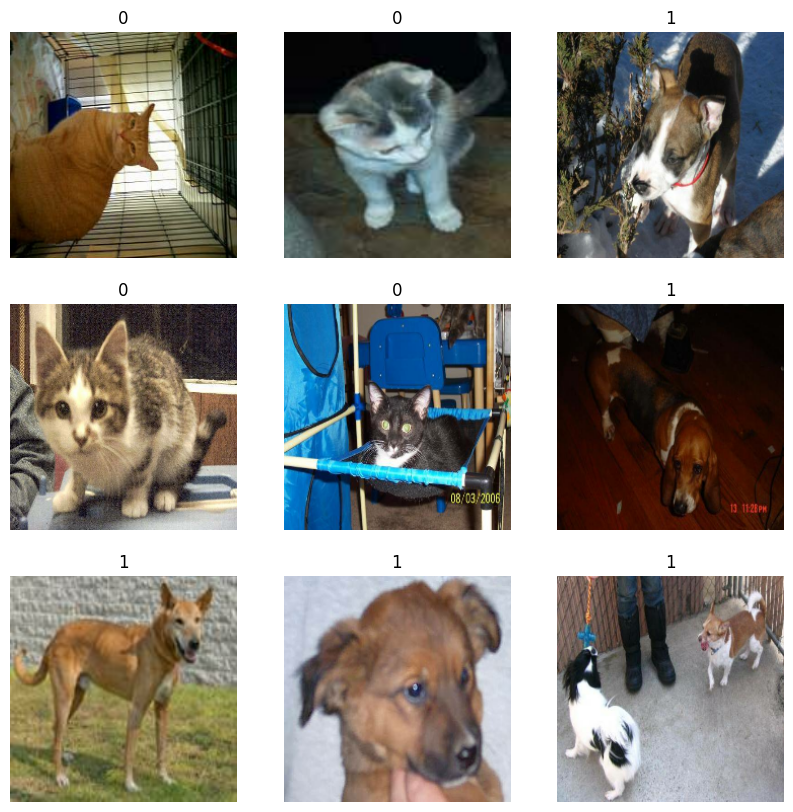

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

#data augmentation

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

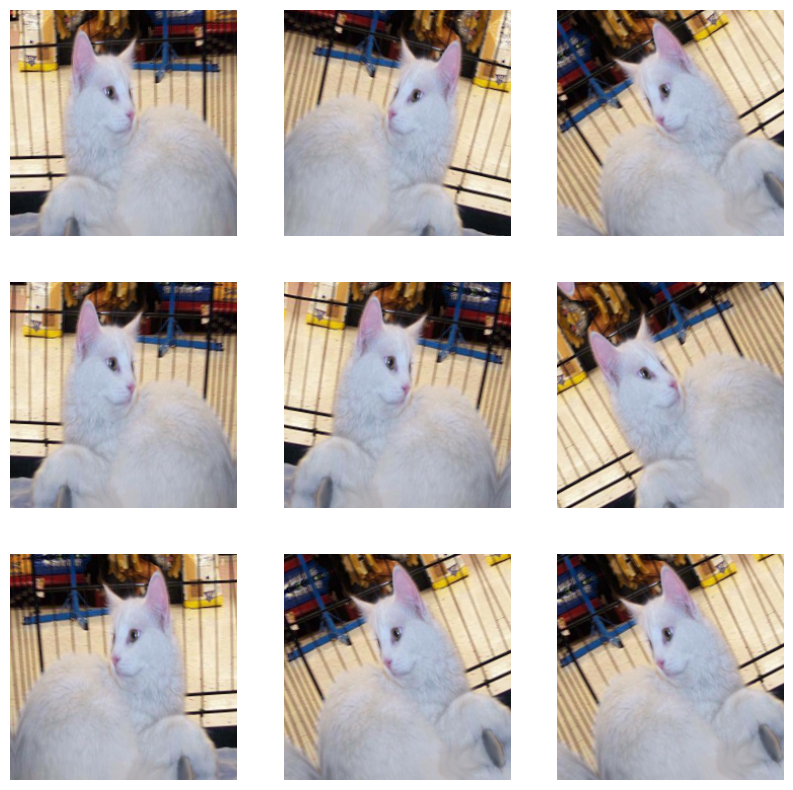

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [14]:
inputs = keras.Input(shape=image_size)
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)

In [15]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

#Use modle MobileNetV2 and Modify

In [36]:
# Dowload network model
model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights="imagenet")

9406464/9406464 [==============================] - 1s 0us/step


In [37]:
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [39]:
avg_model = tf.keras.layers.GlobalAveragePooling2D()(model.output)
pred_layer = tf.keras.layers.Dense(units=1, activation='sigmoid')(avg_model)

In [42]:
model = tf.keras.models.Model(inputs=model.input, outputs=pred_layer)

In [43]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_4[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

In [44]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [45]:
history = model.fit(train_ds, epochs=25, validation_data=val_ds)

Epoch 1/25
141/141 [==============================] - 193s 1s/step - loss: 0.0776 - acc: 0.9694 - val_loss: 0.4377 - val_acc: 0.8122
Epoch 2/25
141/141 [==============================] - 161s 1s/step - loss: 0.0333 - acc: 0.9871 - val_loss: 0.3041 - val_acc: 0.9009
Epoch 3/25
141/141 [==============================] - 159s 1s/step - loss: 0.0219 - acc: 0.9924 - val_loss: 0.0992 - val_acc: 0.9689
Epoch 4/25
141/141 [==============================] - 159s 1s/step - loss: 0.0146 - acc: 0.9948 - val_loss: 0.1528 - val_acc: 0.9667
Epoch 5/25
141/141 [==============================] - 158s 1s/step - loss: 0.0128 - acc: 0.9958 - val_loss: 0.1079 - val_acc: 0.9736
Epoch 6/25
141/141 [==============================] - 158s 1s/step - loss: 0.0091 - acc: 0.9969 - val_loss: 0.0709 - val_acc: 0.9833
Epoch 7/25
141/141 [==============================] - 165s 1s/step - loss: 0.0079 - acc: 0.9976 - val_loss: 0.1425 - val_acc: 0.9729
Epoch 8/25
141/141 [==============================] - 158s 1s/step - 

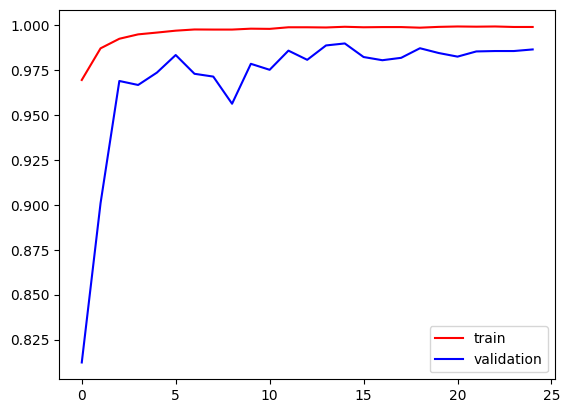

In [46]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'],color='red',label='train')
plt.plot(history.history['val_acc'],color='blue',label='validation')
plt.legend()
plt.show()

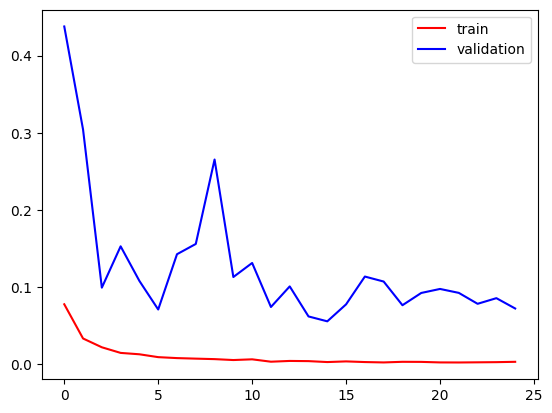

In [47]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

#predict

1/1 [==============================] - 1s 1s/step
This image is 0.00% cat and 100.00% dog.


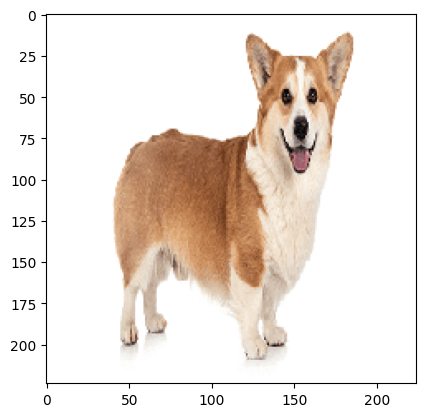

In [48]:
img = keras.utils.load_img(
    "/content/copy-of-01-corgi_1684397090462.png", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

#build model by trial and error

In [20]:
model1 = Sequential()

model1.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(224,224,3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model1.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model1.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model1.add(Flatten())

model1.add(Dense(128,activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.1))
model1.add(Dense(1,activation='sigmoid'))

In [21]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_3 (Bat  (None, 222, 222, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_4 (Bat  (None, 109, 109, 64)      256       
 chNormalization)                                                
                                                      

In [18]:
model1.compile(optimizer='re',loss='binary_crossentropy',metrics=['accuracy'])

In [19]:
history1 = model1.fit(train_ds,epochs=25,validation_data=val_ds)

Epoch 1/25
141/141 [==============================] - 160s 977ms/step - loss: 1.5039 - accuracy: 0.5737 - val_loss: 0.8233 - val_accuracy: 0.5716
Epoch 2/25
141/141 [==============================] - 137s 951ms/step - loss: 0.6605 - accuracy: 0.6239 - val_loss: 1.0541 - val_accuracy: 0.6613
Epoch 3/25
141/141 [==============================] - 135s 945ms/step - loss: 0.5815 - accuracy: 0.6817 - val_loss: 0.5268 - val_accuracy: 0.7269
Epoch 4/25
141/141 [==============================] - 136s 950ms/step - loss: 0.5452 - accuracy: 0.7107 - val_loss: 0.5259 - val_accuracy: 0.7389
Epoch 5/25
141/141 [==============================] - 135s 937ms/step - loss: 0.5246 - accuracy: 0.7326 - val_loss: 0.5521 - val_accuracy: 0.7204
Epoch 6/25
141/141 [==============================] - 136s 951ms/step - loss: 0.5082 - accuracy: 0.7362 - val_loss: 0.4945 - val_accuracy: 0.7578
Epoch 7/25
141/141 [==============================] - 136s 951ms/step - loss: 0.4900 - accuracy: 0.7576 - val_loss: 0.5268 -

In [24]:
model1.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [26]:
history_n = model1.fit(train_ds,epochs=25,validation_data=val_ds)

Epoch 1/25
141/141 [==============================] - 156s 963ms/step - loss: 1.7634 - accuracy: 0.5656 - val_loss: 0.6918 - val_accuracy: 0.4958
Epoch 2/25
141/141 [==============================] - 135s 946ms/step - loss: 0.6709 - accuracy: 0.6127 - val_loss: 0.6834 - val_accuracy: 0.5316
Epoch 3/25
141/141 [==============================] - 135s 936ms/step - loss: 0.5918 - accuracy: 0.6839 - val_loss: 0.6524 - val_accuracy: 0.6060
Epoch 4/25
141/141 [==============================] - 135s 947ms/step - loss: 0.5387 - accuracy: 0.7309 - val_loss: 0.5384 - val_accuracy: 0.7198
Epoch 5/25
141/141 [==============================] - 137s 957ms/step - loss: 0.5040 - accuracy: 0.7514 - val_loss: 0.4982 - val_accuracy: 0.7384
Epoch 6/25
141/141 [==============================] - 135s 946ms/step - loss: 0.4785 - accuracy: 0.7763 - val_loss: 0.5445 - val_accuracy: 0.7224
Epoch 7/25
141/141 [==============================] - 133s 937ms/step - loss: 0.4489 - accuracy: 0.7938 - val_loss: 0.4540 -

In [16]:
model2 = models.Sequential()

model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model2.add(layers.MaxPool2D(2, 2))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPool2D(2, 2))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPool2D(2, 2))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPool2D(2, 2))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5)) # Note the only change is that we added dropout here
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [18]:
historyt= model2.fit(train_ds,epochs=10,validation_data=val_ds)

Epoch 1/10
141/141 [==============================] - 2601s 18s/step - loss: 0.6653 - acc: 0.6234 - val_loss: 0.6164 - val_acc: 0.6449
Epoch 2/10
141/141 [==============================] - 2632s 19s/step - loss: 0.6209 - acc: 0.6692 - val_loss: 0.5309 - val_acc: 0.7296
Epoch 3/10
141/141 [==============================] - 2561s 18s/step - loss: 0.5575 - acc: 0.7213 - val_loss: 0.5477 - val_acc: 0.6891
Epoch 4/10
141/141 [==============================] - 2615s 19s/step - loss: 0.5096 - acc: 0.7488 - val_loss: 0.4717 - val_acc: 0.7758
Epoch 5/10
141/141 [==============================] - 2608s 18s/step - loss: 0.4845 - acc: 0.7726 - val_loss: 0.4168 - val_acc: 0.8053
Epoch 6/10
141/141 [==============================] - 2563s 18s/step - loss: 0.4444 - acc: 0.7931 - val_loss: 0.4184 - val_acc: 0.7951
Epoch 7/10
141/141 [==============================] - 2603s 18s/step - loss: 0.4358 - acc: 0.8037 - val_loss: 0.3500 - val_acc: 0.8467
Epoch 8/10
141/141 [==============================] - 2

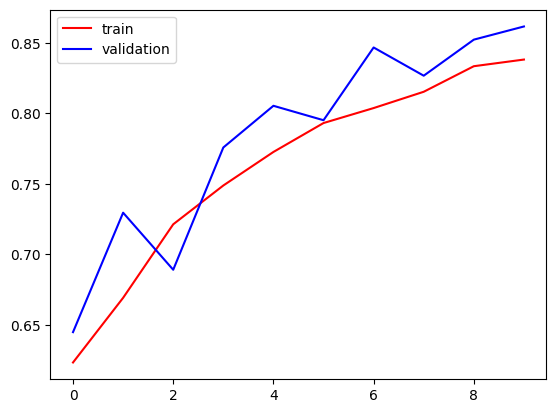

In [19]:
import matplotlib.pyplot as plt

plt.plot(historyt.history['acc'],color='red',label='train')
plt.plot(historyt.history['val_acc'],color='blue',label='validation')
plt.legend()
plt.show()

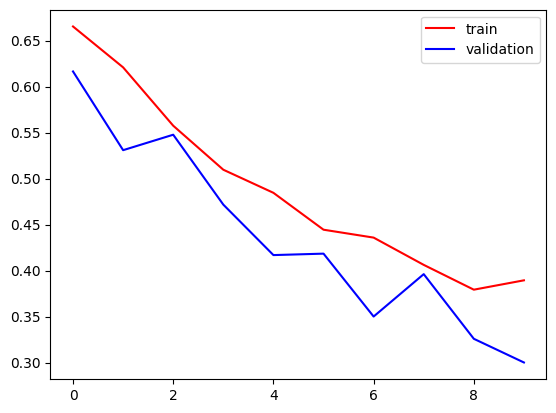

In [20]:
plt.plot(historyt.history['loss'],color='red',label='train')
plt.plot(historyt.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

1/1 [==============================] - 1s 574ms/step
This image is 100.00% cat and 0.00% dog.


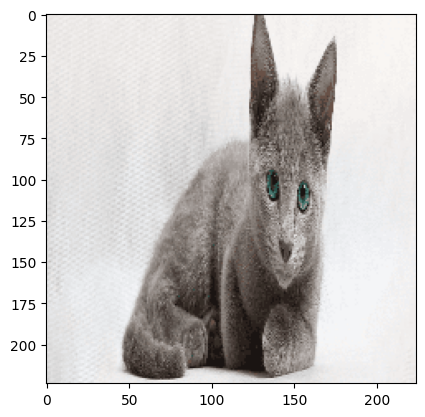

In [21]:
img = keras.utils.load_img(
    "/content/she-how-to-feed-kitten-hero-large-screen_1670509319390.png", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model2.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 99ms/step
This image is 11.39% cat and 88.61% dog.


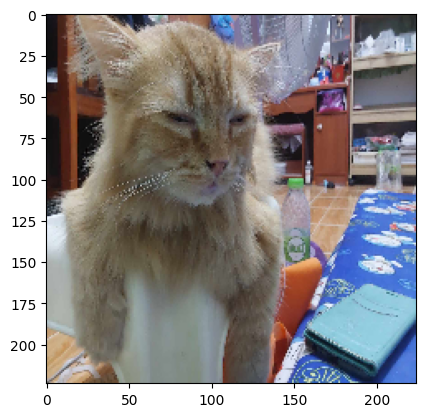

In [23]:
img = keras.utils.load_img(
    "/content/404519726_351364590820365_5520323647052033589_n.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model2.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

1/1 [==============================] - 0s 273ms/step
This image is 80.65% cat and 19.35% dog.


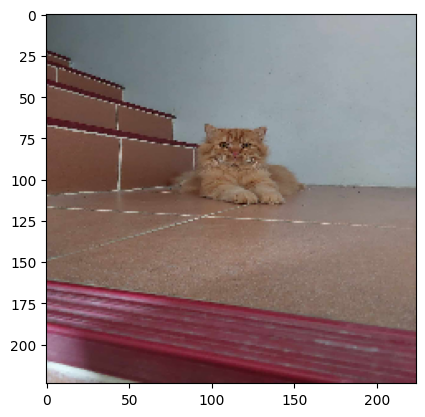

In [24]:
img = keras.utils.load_img(
    "/content/446341959_1137678004283593_7565456607169849595_n.jpg", target_size=image_size
)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model2.predict(img_array)
score = float(predictions[0])
print(f"This image is {100 * (1 - score):.2f}% cat and {100 * score:.2f}% dog.")

#------------------    Summary    ------------------
## MobileNetV2
- เลือกใช้โมเดล MobileNetV2 เพราะมีการ Time (ms) per inference step (GPU) น้อยเมื่อแทนกับตัวอื่น
- มีค่า acc --> 98%
- ต้องปรับmodelให้เข้ากับdataที่เราจะเทรน  

## Model trail and error
- ใช้เวลานานในการเทรน
- มีค่า acc --> 88%
- ยิ่งมี layer มากยิ่งใช่เวลานาน

## เปรียบเทียบ 2 ตัว
- การใช้โมลเดลจาก network ประหยัดเวลาในการเทรนโมเดล > สร้างโมเดลเอง
- การใช้ network model นั้น ให้ค่า acc ดีตั้งแต่ครั้งแรกที่เทรน เป็นเป็นตามที่คาดหวัง > 90%

## ปัญหาที่พบ
- GPU เต็ม ต้องสมัครเมลใหม่
- เน็ตหลุดต้องเริ่มเทรนใหม่

# refer
https://keras.io/api/applications/  

https://keras.io/api/layers/activations/  

https://www.youtube.com/watch?v=SEbWKEwl7K0&t=966s  

https://wtfleming.github.io/blog/keras-cats-vs-dogs-part-1/  

https://keras.io/examples/vision/image_classification_from_scratch/  

https://www.youtube.com/watch?v=0K4J_PTgysc